ML pipeline on toy classification problem

using a scikit-learn pipeline allows gridsearch on preprocessing choices

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pprint as pp
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from utils import process as p
from utils import diagnosis as d

# load data

In [5]:
data_path = '../data/'
raw = pd.read_csv(data_path+'train.csv')
y = raw['SalePrice']
X = raw.copy()
cat_features, cont_features, dates = p.tidy_features_type()

# turn the Ames Housing problem into an arbitrary classification
index_positive_class = (y >= 200000)
y.loc[index_positive_class] = 1
y.loc[np.logical_not(index_positive_class)] = 0

def count(x): return x.value_counts(dropna=False)
def percentage(x): return x.value_counts(normalize=True, dropna=False) * 100
print('binary outcome:')
y.agg([count, percentage]).round(2)

binary outcome:


,count,percentage
0,1025,70.21
1,435,29.79


# preprocess features

In [7]:
# turn into a string to prevent error during transformation
X['MSSubClass'] = X['MSSubClass'].astype(str)
X = p.transform_dates(X, dates)
cont_features.extend(['time_since_built', 'time_since_remod', 'time_since_garage'])
remove_cols = dates + ['date_sold', 'SalePrice', 'Id']
X = X.drop(remove_cols, 1)

print(f"check design matrix dimensions: {len(cat_features) + len(cont_features) + 1 == X.shape[1]}")

# outliers
index_outliers = (X.time_since_built < 0) | (X.time_since_garage < 0) | (X.time_since_remod < 0)
print("#outliers: ", index_outliers.sum())
X = X[np.logical_not(index_outliers)]
y = y[np.logical_not(index_outliers)]

check design matrix dimensions: True
#outliers:  1


# Build pipeline

In [8]:
# transform numerical features
impute_scale = Pipeline(steps=[('impute', SimpleImputer(strategy='mean')), 
                               ('scale', StandardScaler())
                              ])

cont_transformer = FeatureUnion([("impute_scale", impute_scale), 
                                 ("IDmissing", MissingIndicator(features="all"))
                                ])

# transform categorical features
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('OHE', OneHotEncoder(handle_unknown='ignore', sparse=False))])


# assemble transformers
preprocess = ColumnTransformer(
    transformers=[
        ('cont', cont_transformer, cont_features),
        ('cat', cat_transformer, cat_features)
    ])


# feature selection / gridsearch

In [9]:
import sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# estimator = CalibratedClassifierCV(RandomForestClassifier(), cv=3, method='sigmoid')
estimator = RandomForestClassifier()
pipe = Pipeline([
      ('preprocess', preprocess),
      ('selection', VarianceThreshold()),
      ('clf', estimator)
]);

# pp.pprint(sorted(pipe.get_params().keys()))
if 'clf__base_estimator' in pipe.get_params().keys():
    clf_pipe_str = 'clf__base_estimator'
else:
    clf_pipe_str = 'clf'
    
pipe_params = {'preprocess__cont__impute_scale__impute__strategy': ['mean', 'median'],
              f'{clf_pipe_str}__n_estimators': [50,100, 200]
              }
grid = GridSearchCV(pipe, pipe_params, cv=3, iid=False, verbose=2, n_jobs=-1, 
                    return_train_score=True, scoring='neg_median_absolute_error')
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:    1.9s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    2.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.4s finished


{'clf__n_estimators': 50, 'preprocess__cont__impute_scale__impute__strategy': 'mean'}


In [11]:
best_pipe = grid.best_estimator_
df_summary = pd.DataFrame({'actual':y,
                           'pred': best_pipe.predict_proba(X)[:,1],
                           'sample':['train' if (ind in X_train.index) 
                                     else 'test' for ind in X.index]
                          },index=y.index)

y_pred_train = best_pipe.predict_proba(X_train)[:,1]
y_pred_test = best_pipe.predict_proba(X_test)[:,1]

# model results and diagnosis

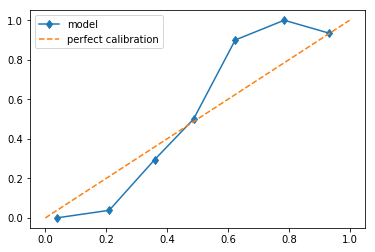

In [12]:
# does the classifier predictions reflect the actual observed probabilities?

frac_pos_bin, mean_pred_bin = calibration_curve(y_test, y_pred_test, n_bins=7)
plt.plot(mean_pred_bin, frac_pos_bin, 'd-', label="model")
plt.plot([0, 1], [0, 1], "--", label="perfect calibration")
plt.legend()

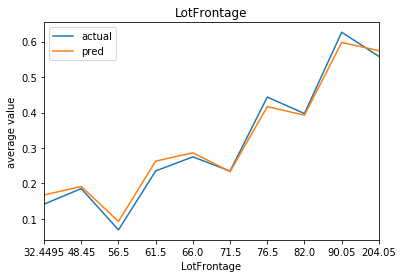

In [15]:
# partial dependence plot: does the estimator model the ground truth closely enough?

feat = 'LotFrontage'
pdp = X[[feat]].copy()
pdp['bins'] = pd.qcut(pdp[feat], 10)
pdp['mid'] = pdp['bins'].apply(lambda x:x.mid)
pdp = pdp.join(df_summary)
pdp.groupby('mid')[['actual', 'pred']].mean().plot()
plt.xlabel(feat)
plt.ylabel('average value')
plt.title(feat);

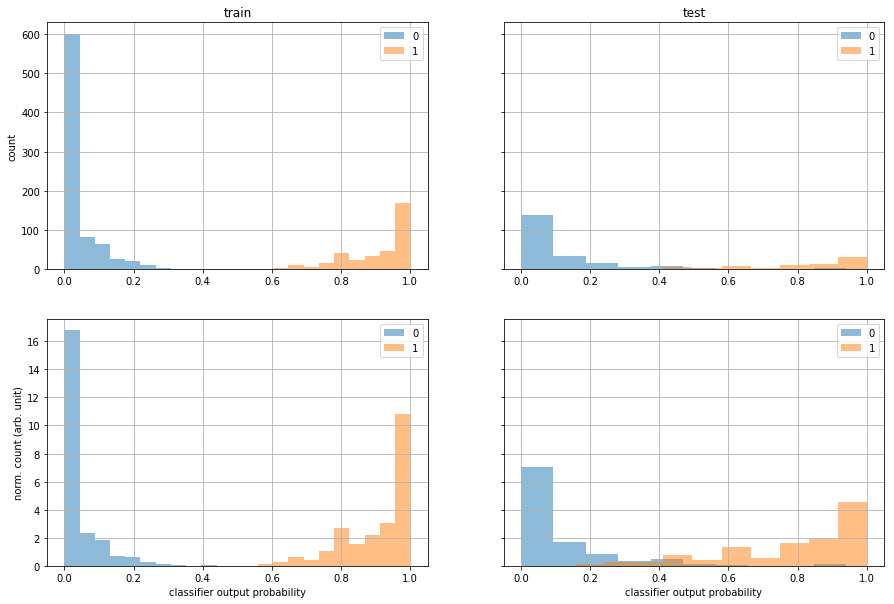

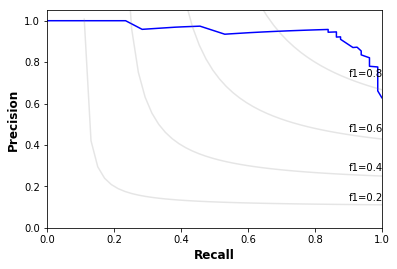

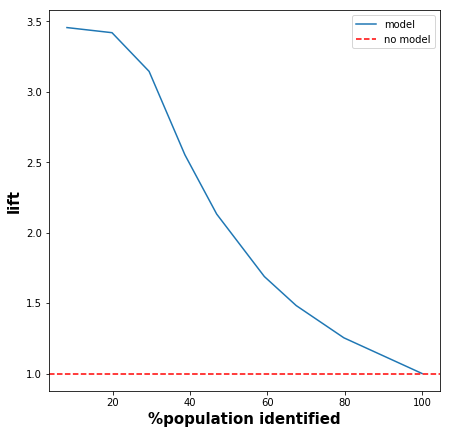

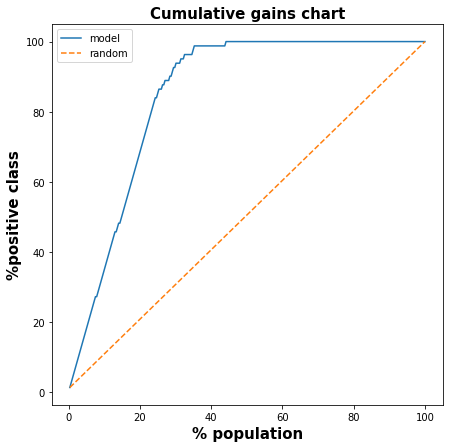

auroc: 0.9831
gini: 0.9662


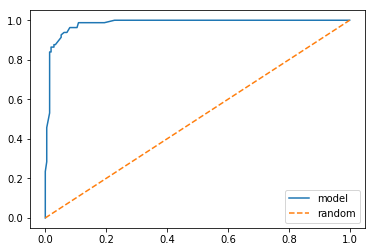

In [16]:
d.class_proba_dist(df_summary)
d.pr_curve(y_test, y_pred_test)
d.lift_curve(y_test, y_pred_test)
d.gain_chart(y_test, y_pred_test)
d.roc(y_test, y_pred_test)